<a href="https://colab.research.google.com/github/alejandrodgb/fastai/blob/main/clean/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if 'google.colab' in sys.modules:
    ! [ -e /content ] && pip install -Uqq fastbook
    !pip install nbdev
    
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Data

In [3]:
# Download sample dataset for MNIST
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
# Review directory
path.ls()

(#3) [Path('/Users/adgb/.fastai/data/mnist_sample/valid'),Path('/Users/adgb/.fastai/data/mnist_sample/labels.csv'),Path('/Users/adgb/.fastai/data/mnist_sample/train')]

In [5]:
# Review training folder
(path/'train').ls()

(#2) [Path('/Users/adgb/.fastai/data/mnist_sample/train/7'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3')]

In [6]:
# Review digit folder contents
(path/'train/3').ls().sorted()

(#6131) [Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10000.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10011.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10031.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10034.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10042.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10052.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/1007.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10074.png'),Path('/Users/adgb/.fastai/data/mnist_sample/train/3/10091.png')...]

In [7]:
train_path = path/'train'

In [8]:
# Review a single image
nums = [i.ls().sorted() for i in train_path.ls().sorted()]

In [9]:
im = Image.open(nums[0][0])
im

In [10]:
# Review image values
print(im.shape)
tensor(im)[4:10,4:10]

(28, 28)


tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

# Recognising digits

## Pixel similarity

Finding the average 3/7 by calculating the average value accross all images

In [11]:
# Create a list of all images
nums_lists = [[tensor(Image.open(im)) for im in num] for num in nums]

In [12]:
# Stack all tensors convert to float and normalise.
nums_tensors = [torch.stack(nums_list).float()/255 for nums_list in nums_lists]
[t.shape for t in nums_tensors]

[torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28])]

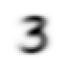

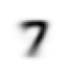

In [13]:
# Find the average digit
mean_digits = [t.mean(0) for t in nums_tensors]
for d in mean_digits:
    show_image(d)

We will test the absolute value of differences (L1 norm) and the root mean squared error (L2 norm as loss functions.

In [14]:
test_d3 = nums_tensors[0][1]

In [15]:
# Sample L1 and L2 norms for a 3 digit against mean 3
L1_3_3 = (test_d3-mean_digits[0]).abs().mean()
L2_3_3 = ((test_d3-mean_digits[0])**2).mean().sqrt()
L1_3_3, L2_3_3

(tensor(0.1114), tensor(0.2021))

In [16]:
# Sample L1 and L2 norms for a 3 digit against mean 7
L1_3_7 = (test_d3-mean_digits[1]).abs().mean()
L2_3_7 = ((test_d3-mean_digits[1])**2).mean().sqrt()
L1_3_7, L2_3_7

(tensor(0.1586), tensor(0.3021))

These are avaialble in `torch.nn.functional`

In [17]:
(F.l1_loss(test_d3,mean_digits[0]), 
 F.mse_loss(test_d3,mean_digits[0]).sqrt())

(tensor(0.1114), tensor(0.2021))

## Validation set

In [18]:
valid_path = path/'valid'
valid_path.ls()

(#2) [Path('/Users/adgb/.fastai/data/mnist_sample/valid/7'),Path('/Users/adgb/.fastai/data/mnist_sample/valid/3')]

In [19]:
valid_nums = [i.ls().sorted() for i in valid_path.ls().sorted()]
valid_nums_lists = [[tensor(Image.open(im)) for im in num] for num in valid_nums]
valid_nums_tensors = [torch.stack(nums_list).float()/255 for nums_list in valid_nums_lists]
[t.shape for t in valid_nums_tensors]

[torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28])]

In [20]:
# Define an L1 norm function
def mnist_distance(a,b):
    return (a-b).abs().mean((-2,-1))

In [21]:
# Test mnist_distance
mnist_distance(test_d3,mean_digits[0])

tensor(0.1114)

In [22]:
# Calculating for all items in list
mnist_distance(valid_nums_tensors[0],mean_digits[0]).shape

torch.Size([1010])

In [23]:
# Creating a function to predict the group of the digit
def is_3(x): return mnist_distance(x,mean_digits[0])<mnist_distance(x,mean_digits[1])

In [24]:
# Testing on test digit
is_3(test_d3)

tensor(True)

In [25]:
# Testing on all validation dataset
is_3(valid_nums_tensors[0])

tensor([ True,  True,  True,  ..., False,  True,  True])

In [26]:
# Calculating the accuracy of the prediction model
accuracy_3s = is_3(valid_nums_tensors[0]).float().mean()
accuracy_7s = (1-is_3(valid_nums_tensors[1]).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# SGD - Stochastic Gradient Descent

## SGD Introduction Example

This example will demonstrate SGD with a simple function

In [27]:
# Define a simple quadratic function
def f(x): return x**2

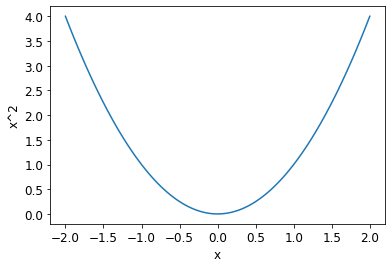

In [28]:
# Plot function
plot_function(f, 'x','x^2')

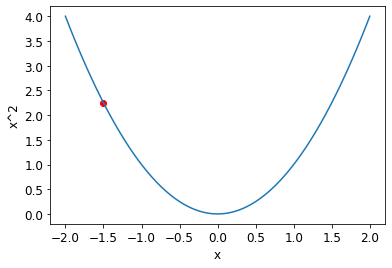

In [29]:
# Step 1: initiate random weight for a parameter and calculate the loss
plot_function(f, 'x','x^2')
plt.scatter(-1.5,f(-1.5), color='r');

In [30]:
# Step 2: Calculate the gradient

# 2.1 allocate a value
xt = tensor(3.0).requires_grad_()

# 2.2 Calculate the function to be backpropagated with the desired value
yt = f(xt)
print(f'f(x) = x^2 =', yt)

f(x) = x^2 = tensor(9., grad_fn=<PowBackward0>)


In [31]:
# 2.3 Calculate the gradient
yt.backward()

In [32]:
# Gradient of the value
xt.grad

tensor(6.)

This can also be done with a vector

In [33]:
xt = tensor([2.,3.,5.]).requires_grad_()
xt

tensor([2., 3., 5.], requires_grad=True)

In [34]:
# Redefine function to return a scalar
def f(x): return (x**2).sum()

In [35]:
# Calculate the function to be backpropagated
yt = f(xt)
yt

tensor(38., grad_fn=<SumBackward0>)

In [36]:
# Calculate gadients
yt.backward()
xt.grad

tensor([ 4.,  6., 10.])

## SGD full example 

Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:


In [37]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

In [38]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2+1

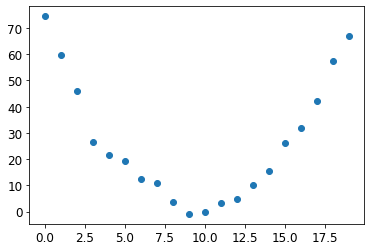

In [39]:
plt.scatter(time,speed);

We will try to find the function that will best fit the curve. The function below allows us to try many different quadratic functions to learn which one applies.

In [40]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

We also need to define a function to measure how far our predictions are from the actual value.

In [41]:
# Loss function
def mse(preds, targs): return ((preds-targs)**2).mean().sqrt()

In [58]:
# Step 1: Initialise parameters
params = torch.rand(3).requires_grad_()
params

tensor([0.3423, 0.6343, 0.3644], requires_grad=True)

In [44]:
# Function to show predictions
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

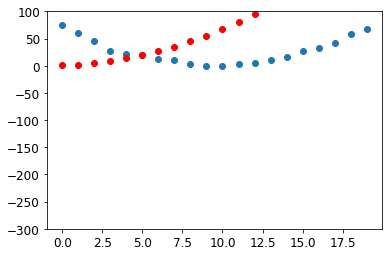

In [45]:
# Step 2: Predict
preds = f(time, params)
show_preds(preds)

In [46]:
# Step 3: Loss
loss = mse(preds,speed)
loss

tensor(88.0970, grad_fn=<SqrtBackward0>)

In [47]:
# Step 4: Gradient
loss.backward()
params.grad

tensor([159.9897,  10.3568,   0.6122])

In [48]:
# Step 5: Step (adjust gradients)
lr = 1e-3
params.data -= lr*params.grad.data
params.grad = None

In [49]:
# Check wheter loss has improved 
preds = f(time,params)
mse(preds,speed)

tensor(62.9148, grad_fn=<SqrtBackward0>)

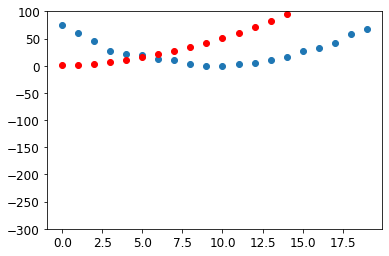

In [50]:
show_preds(preds)

In [53]:
# Create a loop to run through the seven steps
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds,speed)
    loss.backward()
    params.data -= lr*params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [54]:
# Run through 10 iterations
for i in range(10): apply_step(params)

62.91476821899414
41.09331130981445
28.21217918395996
26.443716049194336
26.443531036376953
26.443355560302734
26.443174362182617
26.442995071411133
26.44281578063965
26.442636489868164


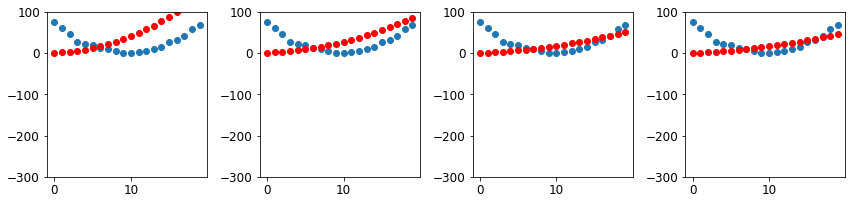

In [59]:
# Plotting loss improvement
fig, axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False),ax)
plt.tight_layout()

# MNIST loss

In [62]:
# Concatenate all digits to a single tensor and reshape tensor from a rank-3 to
# a rank-2 tensor.
train_x = torch.cat(nums_tensors).view(-1,28*28)
train_x.shape, [t.shape for t in nums_tensors]

(torch.Size([12396, 784]),
 [torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28])])

In [65]:
# Create labels for image training. 3s will be 1, 7s will be 0
train_y = tensor([1]*len(nums_tensors[0])+[0]*len(nums_tensors[1])).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [72]:
# Create PyTorch dataset
dset = list(zip(train_x, train_y))
x,y = dset[0] #Extract a sample
x.shape, y

(torch.Size([784]), tensor([1]))

In [74]:
# Create validation data
valid_x = torch.cat(valid_nums_tensors).view(-1,28*28)
valid_x.shape, [t.shape for t in valid_nums_tensors]

(torch.Size([2038, 784]),
 [torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28])])

In [75]:
# Create validation labels
valid_y = tensor([1]*len(valid_nums_tensors[0])+[0]*len(valid_nums_tensors[1])).unsqueeze(1)
valid_y.shape

torch.Size([2038, 1])

In [76]:
# Create PyTorch dataset
valid_dset = list(zip(valid_x, valid_y))

In [77]:
# Step 1: Initialise parameters
def init_params(size, std=1): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

In [87]:
# Step 2 test: Prediction for single image
# The prediction function is in the form of wx+b

(x*weights.T).sum() + bias

tensor([6.2723], grad_fn=<AddBackward0>)

In [88]:
# Step 2: Predict for all images

# Define matrix multiplication
def linear1(xb): return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ 6.2723],
        [14.5506],
        [10.4807],
        ...,
        [ 3.6741],
        [20.7852],
        [ 4.6783]], grad_fn=<AddBackward0>)

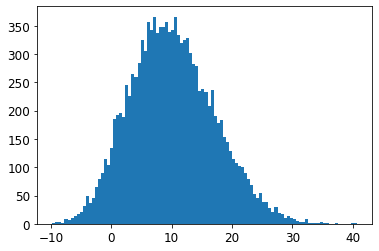

In [102]:
with torch.no_grad():
        plt.hist(preds.numpy(),bins=100)

In [105]:
# Accuracy
corrects = (preds>0.0).float() == train_y
corrects.float().mean().item()

0.48604387044906616

In [106]:
preds.shape

torch.Size([12396, 1])

In [124]:
# MNIST loss function - 3s are coded as ones
def mnist_loss(predictions, targets):
    return torch.where(targets==1,1-predictions,predictions).mean()

In [128]:
# Loss function test
test_targs = torch.tensor([1,0,0,1,1])
te1st_preds = torch.tensor([.9,.2,.9,.1,.99])
mnist_loss(test_preds, test_targs)

tensor(0.4220)

## Sigmoid

In [129]:
# Sigmoid function to cap results between 0 and 1
def sigmoid(x): return 1/(1+torch.exp(-x))

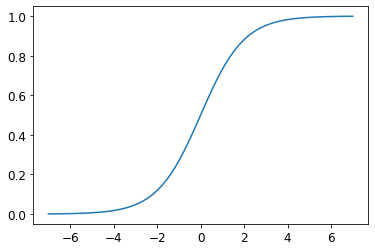

In [132]:
plot_function(sigmoid,min=-7,max=7)

In [134]:
# Redefine MNIST loss with a sigmoid activation
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1,1-predictions,predictions).mean()

# Minibatches

In [135]:
# Minibatch sample using FastAI DataLoaders
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [140]:
dl = DataLoader(ds,batch_size=6,shuffle=True)
list(dl)

[(tensor([ 7,  4, 20, 19,  5, 25]), ('h', 'e', 'u', 't', 'f', 'z')),
 (tensor([22, 13, 18,  0,  6, 16]), ('w', 'n', 's', 'a', 'g', 'q')),
 (tensor([10,  1, 21,  8, 24, 17]), ('k', 'b', 'v', 'i', 'y', 'r')),
 (tensor([23, 14,  3, 12, 11,  2]), ('x', 'o', 'd', 'm', 'l', 'c')),
 (tensor([ 9, 15]), ('j', 'p'))]

# Training with SGD

Triaining loop template:

``` python
for x,y in dl:
    preds = model(x)
    loss = loss_func(pred,y)
    loss.backward()
    params -= lr*params.grad
```

In [155]:
# Step 1: Initialise parameters
weights = init_params((28*28,1))
bias = init_params(1)

In [156]:
# Create training dataloader
dl = DataLoader(dset,batch_size=256)

# Create validation dataloader
valid_dl = DataLoader(valid_dset,batch_size=256)

In [157]:
# Testing on a minibatch
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [177]:
preds = linear1(batch)
preds

tensor([[-4.6232],
        [-7.4796],
        [-7.2658],
        [-7.8962]], grad_fn=<AddBackward0>)

In [160]:
loss = mnist_loss(preds,train_y[:4])
loss

tensor(0.9972, grad_fn=<MeanBackward0>)

In [161]:
# Calculate the gradients
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0004), tensor([-0.0028]))

In [162]:
# Creating a function to calculate gradients
def calc_grad(xb, yb, model, loss_fn):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    loss.backward()

In [178]:
# Testing calc_grad
calc_grad(batch,train_y[:4],linear1,mnist_loss)

In [179]:
weights.grad.mean(), bias.grad

(tensor(-0.0012), tensor([-0.0084]))

Gradients are calculated every time a function is run. They need to be zeroed before the calculation is run again for training.

In [166]:
# Function for epoch training
def train_epoch(model, lr, params, loss_fn):
    for xb, yb in dl:
        calc_grad(xb, yb, model, loss_fn)
        for p in params:
            p.data -= lr * p.grad
            p.grad.zero_()

In [167]:
# Function to calculate accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [180]:
# Test batch accuracy
batch_accuracy(linear1(batch),train_y[:4])

tensor(0.)

In [175]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb),yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)

In [181]:
validate_epoch(linear1)

0.5459

We will run through a couple iterations to see if accuracy improves

In [182]:
# Single epoch
lr = 1.0
params = weights, bias
train_epoch(linear1, lr, params, mnist_loss)
validate_epoch(linear1)

0.6743

In [183]:
# Multiple epochs
for i in range(20):
    train_epoch(linear1, lr, params, mnist_loss)
    print(validate_epoch(linear1),end=' ')

0.8344 0.8969 0.9233 0.9365 0.9448 0.9506 0.954 0.9589 0.9633 0.9648 0.9677 0.9677 0.9687 0.9692 0.9687 0.9696 0.9701 0.9711 0.9716 0.9721 

# Creating an optimizer

We can use the PyTorch `nn.Linear` module to replace both `init_weights` and `linear1`

In [184]:
# Create a linear model with PyTorch module
linear_model = nn.Linear(28*28,1)

In [187]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can create a basic optimiser class using the `nn.Linear` module

In [188]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def step(self,*args,**kwargs):
        for p in self.params:
            p.data -= self.lr * p.grad.data
            
    def zero_grad(self,*args,**kwargs):
        for p in self.params:
            p.grad = None

The model optimizer is created by passing the model parameters

In [190]:
opt = BasicOptim(linear_model.parameters(),lr)

We can then modify our training loop

In [192]:
def train_epoch(model,loss_fn):
    for xb,xy in dl:
        calc_grad(xb,xy,model,loss_fn)
        opt.step()
        opt.zero_grad()

In [193]:
def train_model(model,epochs,loss_fn):
    for i in range(epochs):
        train_epoch(model,loss_fn)
        print(validate_epoch(model),end=' ')

In [195]:
train_model(linear_model,20,mnist_loss)

0.4932 0.9131 0.8042 0.9028 0.9292 0.9448 0.9546 0.9614 0.9663 0.9668 0.9697 0.9717 0.9731 0.9751 0.9756 0.9761 0.9775 0.978 0.978 0.978 

The `SGD` fastai class does the same thing as BasicOptim

In [196]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(),lr)
train_model(linear_model,20,mnist_loss)

0.4932 0.9053 0.8115 0.9087 0.9312 0.9458 0.9551 0.9624 0.9648 0.9668 0.9697 0.9717 0.9736 0.9751 0.9761 0.9761 0.9775 0.9775 0.9785 0.979 

The fastai `Learner.fit` can be used instead of `train_model`. The `Learner.fit` method needs fastai `DataLoaders`

In [198]:
# Create data loaders
dls = DataLoaders(dl,valid_dl)

In [199]:
# Create learner
learn = Learner(dls, nn.Linear(28*28,1),loss_func=mnist_loss,opt_func=SGD,metrics=batch_accuracy)

In [200]:
# Fit the data
learn.fit(10,lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.635446,0.502862,0.495584,00:00
1,0.389183,0.279155,0.731600,00:00
2,0.148363,0.151797,0.863592,00:00
3,0.068061,0.097185,0.918548,00:00
4,0.038274,0.073173,0.936212,00:00
5,0.026484,0.059581,0.950442,00:00
6,0.021548,0.050947,0.956820,00:00
7,0.019288,0.045112,0.963199,00:00
8,0.018094,0.040950,0.966143,00:00
9,0.017343,0.037845,0.968106,00:00


# Adding a non-linearity

In [201]:
# Sample definition of a simple neural network 
def simple_net(xb):
    res = xb@w1 + b1 # First linear function
    res = res.max(tensor(0.0)) # Non linearity
    res = res@w2 + b2 # Second linear function
    return res

`w1, w2` are weight tensors, and `b1, b2` are bias tensors.

In [202]:
w1 = init_params((28*28,30)) # 28*28 input activations and 30 output activations
w2 = init_params((30,1)) # 30 input activations and 1 output activation
b1, b2 = init_params(1), init_params(1)

`w1` creates 30 output features, `w2` must have 30 input features

In [203]:
# Replacing code with PyTorch code
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [204]:
learn = Learner(dls, simple_net, loss_func=mnist_loss, opt_func=SGD, 
                metrics=batch_accuracy)

In [205]:
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.298985,0.417945,0.504907,00:00
1,0.142501,0.225772,0.808145,00:00
2,0.079821,0.114895,0.914622,00:00
3,0.053057,0.078040,0.940137,00:00
4,0.040589,0.061116,0.954367,00:00
5,0.034171,0.051560,0.963199,00:00
6,0.030445,0.045512,0.965653,00:00
7,0.027995,0.041373,0.966634,00:00
8,0.026215,0.038358,0.968106,00:00
9,0.024826,0.036061,0.968597,00:00


We can plot the metric by using `recorder`. Recorder is a callback that registers statistics (lr, loss and metrics) during training

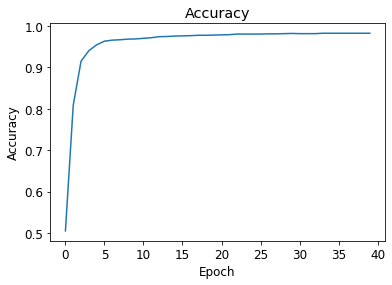

In [216]:
# Plot metric
plt.plot(L(learn.recorder.values).itemgot(2))
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

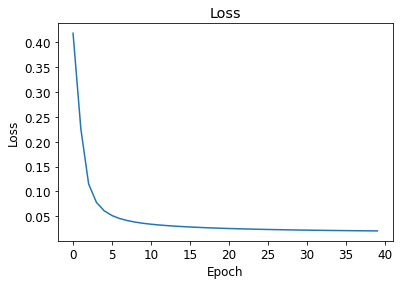

In [217]:
# Plot loss
plt.plot(L(learn.recorder.values).itemgot(1))
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');